Нам предлагается предсказать стоимость дома полагаясь на 79 пояснительных переменных, описывающих почти каждый аспект жилых домов в Эймесе, штат Айова.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.csv', index_col = 0)
test = pd.read_csv('test.csv', index_col = 0)
train.shape, test.shape

((1460, 80), (1459, 79))

In [3]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Знакомство с данными

Данные содержат чсиловые и категориальные признаки. Признак SalePrice является целевым, его и будем предсказывать. Имеются пропуски NaN.

In [4]:
df = pd.concat([train.drop(['SalePrice'], axis = 1), test], axis = 0)

In [5]:
y_train = train['SalePrice']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 79 columns):
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-null object
Exterior2nd      2918 non

Итак, у нас есть 37 числовых и 43 категориальных признаков. Видно, что есть признаки с огромным кол-вом пропусков, скорее всего будем от них избавляться. Однако рассмотреть придется каждый признак. Для удобства будем рассматривать численные и категориальные признаки по отдельности.

In [7]:
num_feat = df.select_dtypes(exclude = ['O']).drop(['MSSubClass'], axis = 1).copy()
cat_feat = df.select_dtypes(include = ['O']).copy()
cat_feat['MSSubClass'] = df['MSSubClass'] # MSSubClass является категориальным признаком хоть и записан в виде числа

### Анализ численных признаков

Имеющиеся численные признаки можно разбить на две части, и посмотреть на них отдельно. У нас есть стобцы, значения которых распределяются среди небольшого кол-ва значений. Например кол-во ванных комнат. И более распределенные признаки, например площадь участка в квадратных футах.

In [8]:
num_easy = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 
            'MoSold', 'YrSold']
num_hard = []
for col in num_feat.columns:
    if col not in num_easy:
        num_hard.append(col)

Для числовых признак важно посмотреть на их распределение, а также на их статистические характеристики. Для визуализации я использую Distplot. Для поиска артефактов Boxplots.


In [9]:
len(num_hard)

22

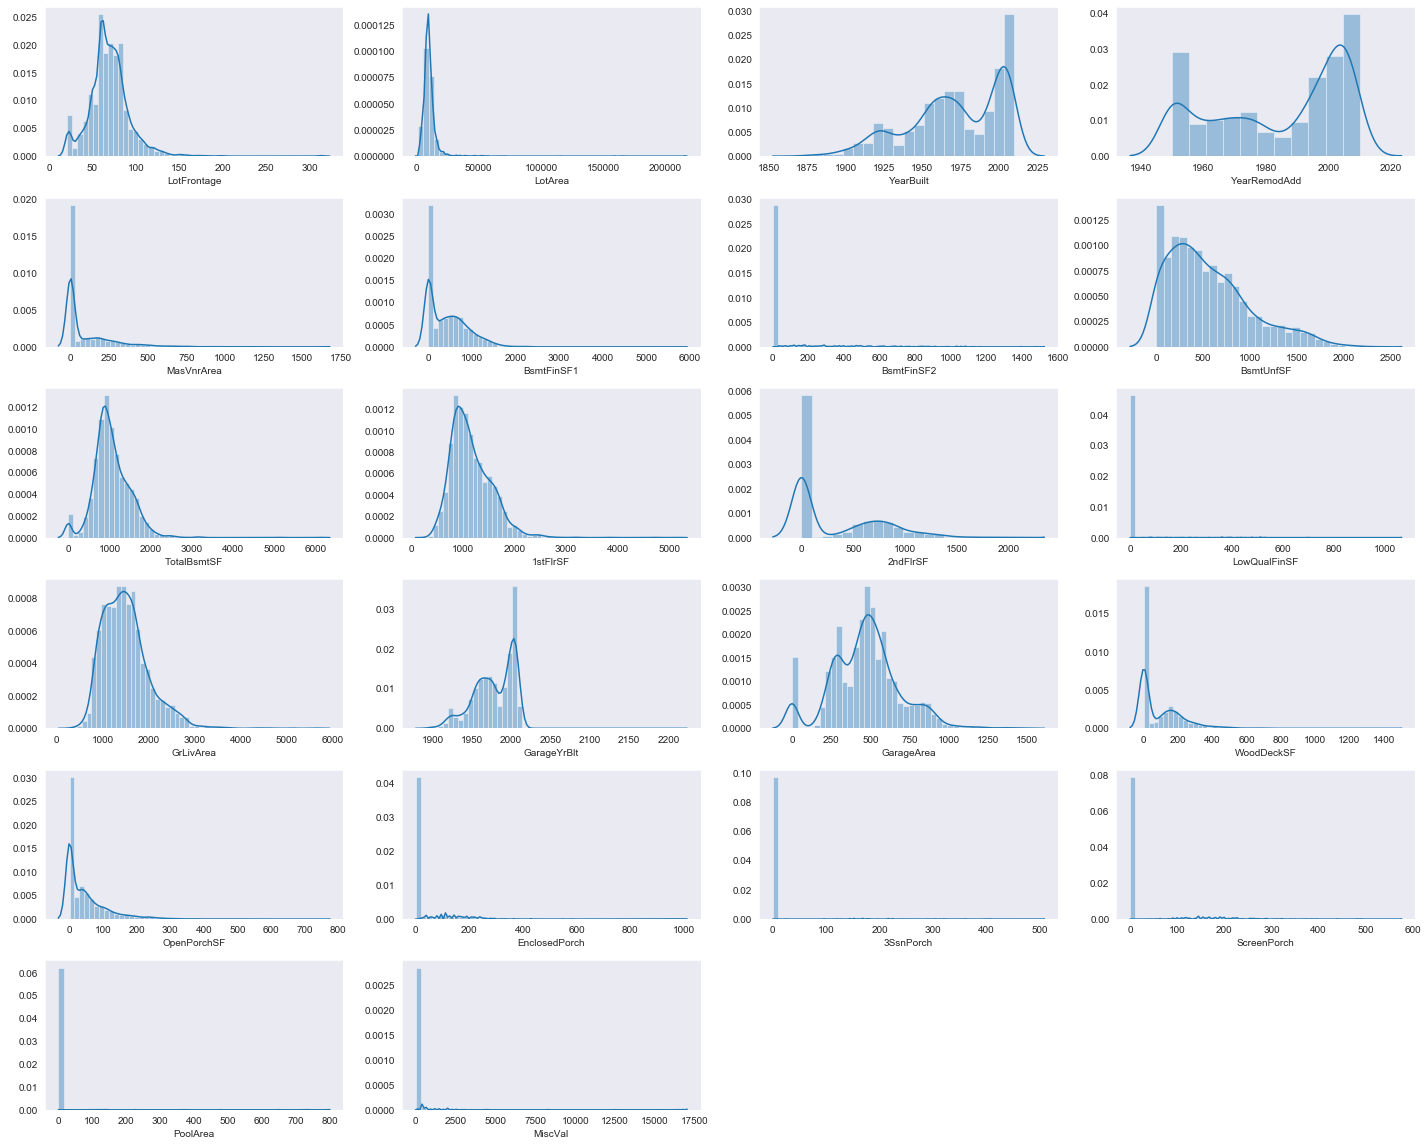

In [10]:
sns.set_style('dark')
fig = plt.figure(figsize = (20,16))
for index, col in enumerate(num_hard):
    plt.subplot(6,4, index+1)
    sns.distplot(num_feat.loc[:, col].dropna())
fig.tight_layout(pad = 1)

Признаки BsmtFinSF2 LowQualFinSF EnclosedPorch 3SsnPorch ScreenPorch PoolArea MiscVal принимают значение 0 почти по всей выборке. Для модели такие данные не несут никакой роли. Их следует удалить.


С помощью boxplot построим графики плотности распределения значений признаков, чтобы увидеть есть ли в данных выбросы.

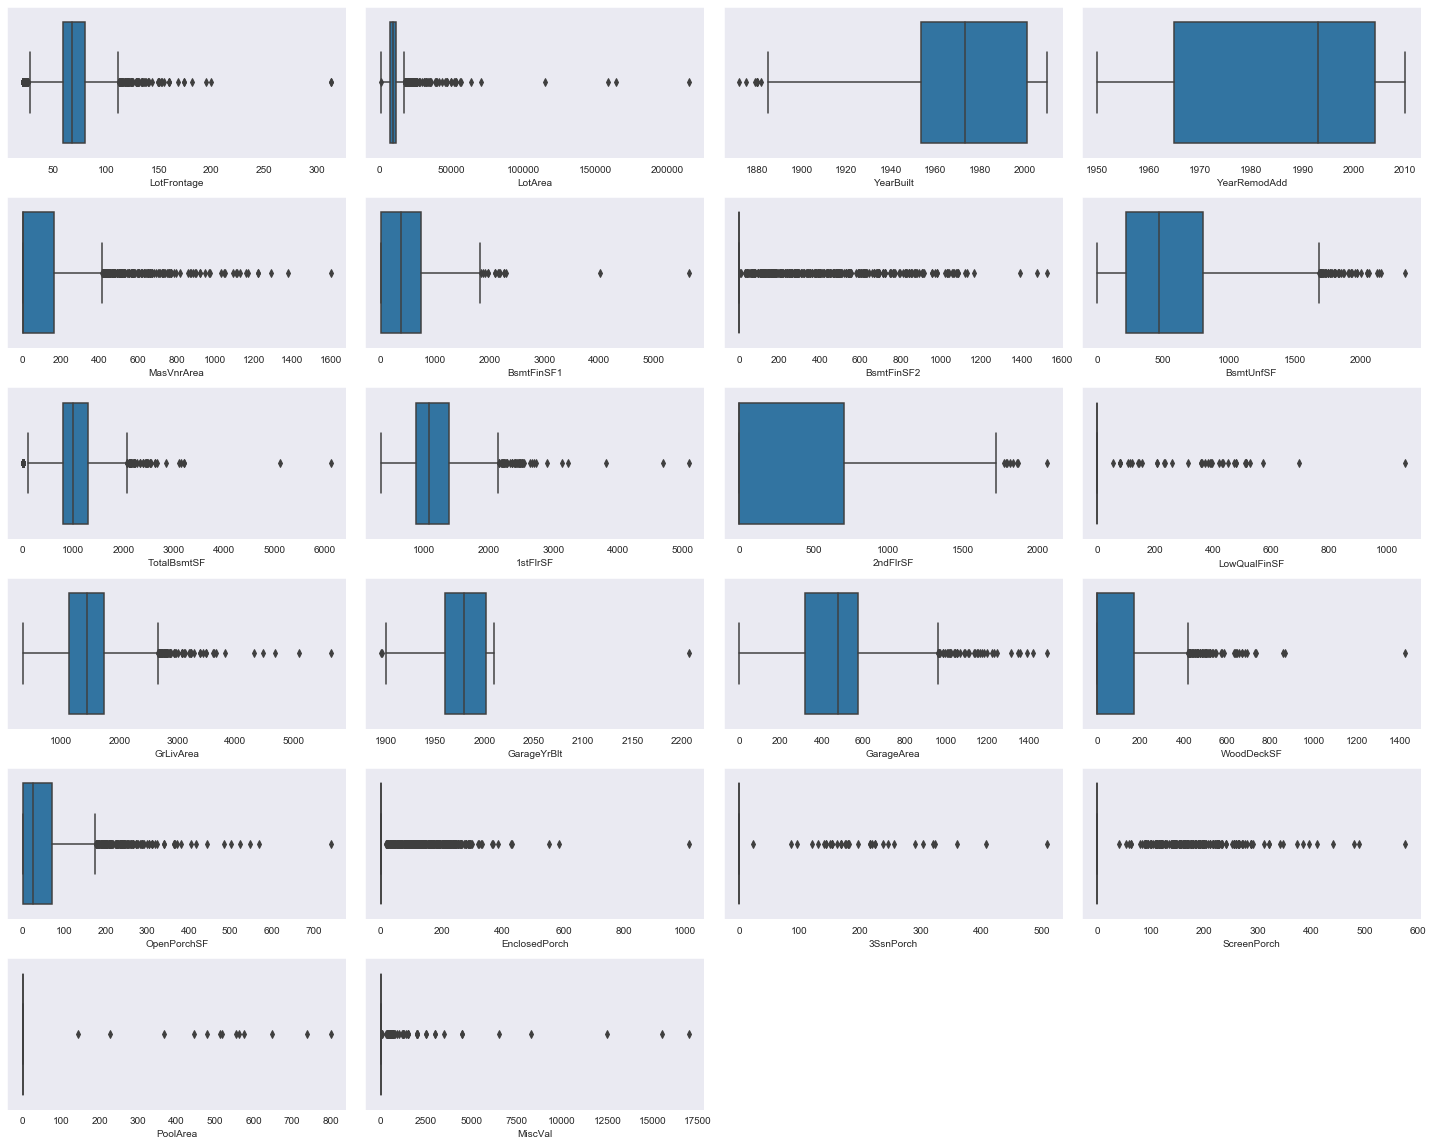

In [11]:
fig = plt.figure(figsize = (20,16))
for index, col in enumerate(num_hard):
    plt.subplot(6,4, index+1)
    sns.boxplot(num_feat.loc[:, col].dropna())
fig.tight_layout(pad = 1)

Можно заметить, что в следующих признаках имеются выбросы, которые смогут негативно сказать на нашей модели
- LotFrontage
- LotArea
- BsmtFinSF1
- TotalBsmtSF
- GrLivArea

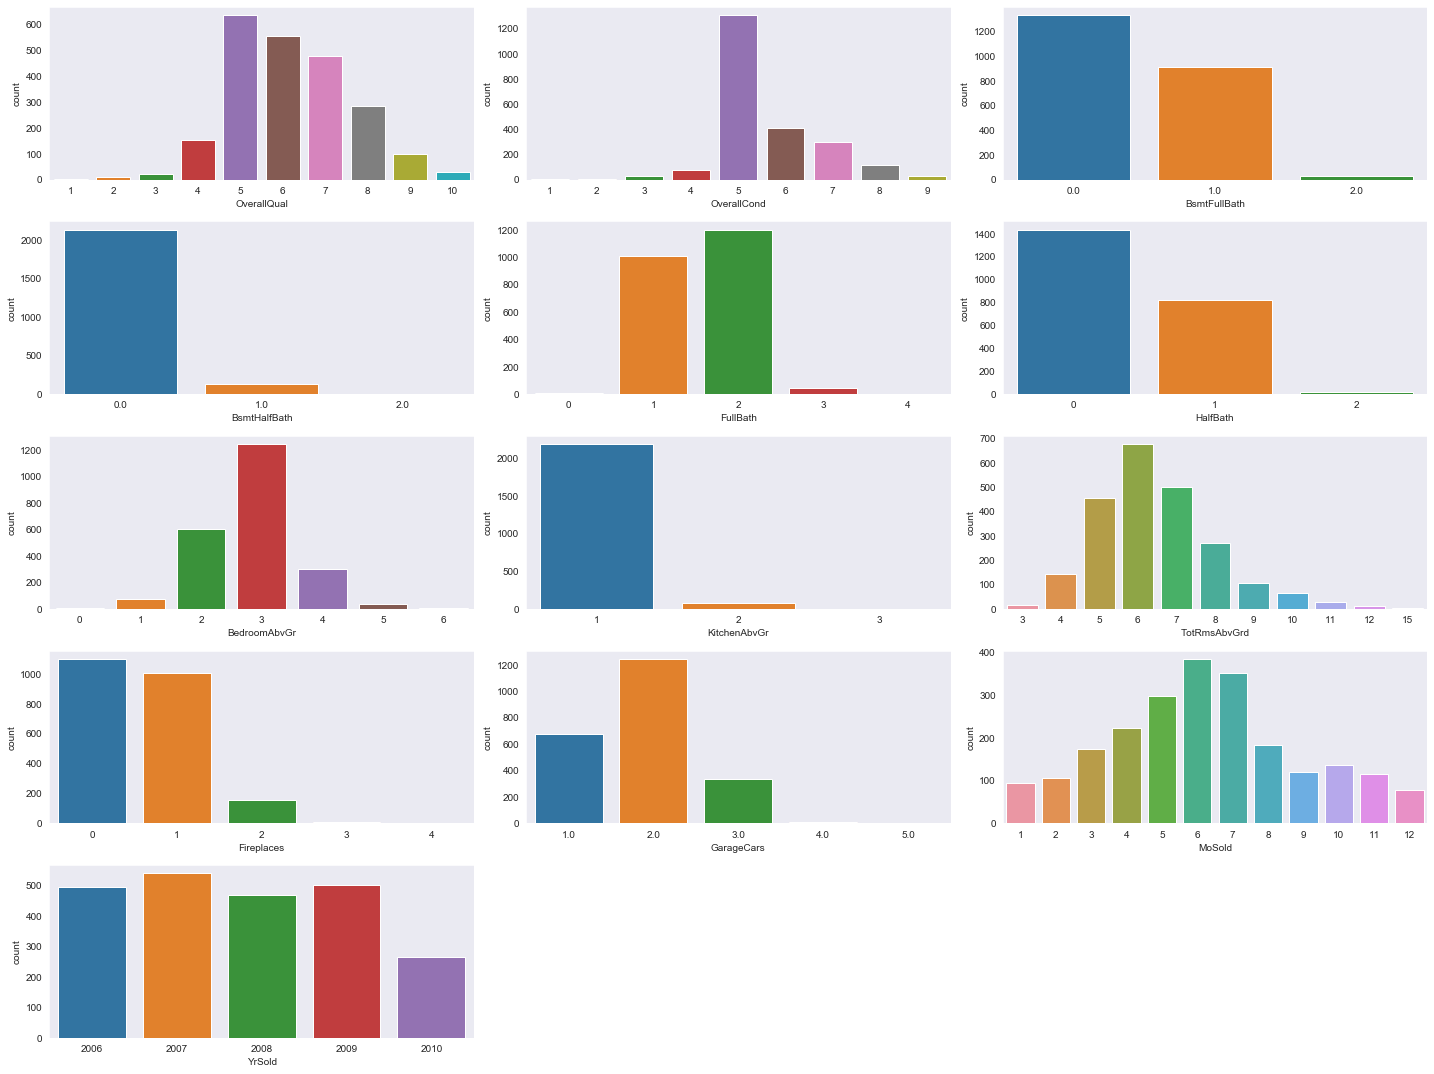

In [12]:
fig = plt.figure(figsize=(20,15))
for index,col in enumerate(num_easy):
    plt.subplot(5,3,index+1)
    sns.countplot(x=col, data=num_feat.dropna())
fig.tight_layout(pad=1.0)

Достаточно большое кол-во признаков имеют редковстречающиеся значения, возможно придется каким-нибудь образом фильтровать данные, т.к. такие значения признаков не будут нести пользу для модели.

### Анализ категориальных признаков

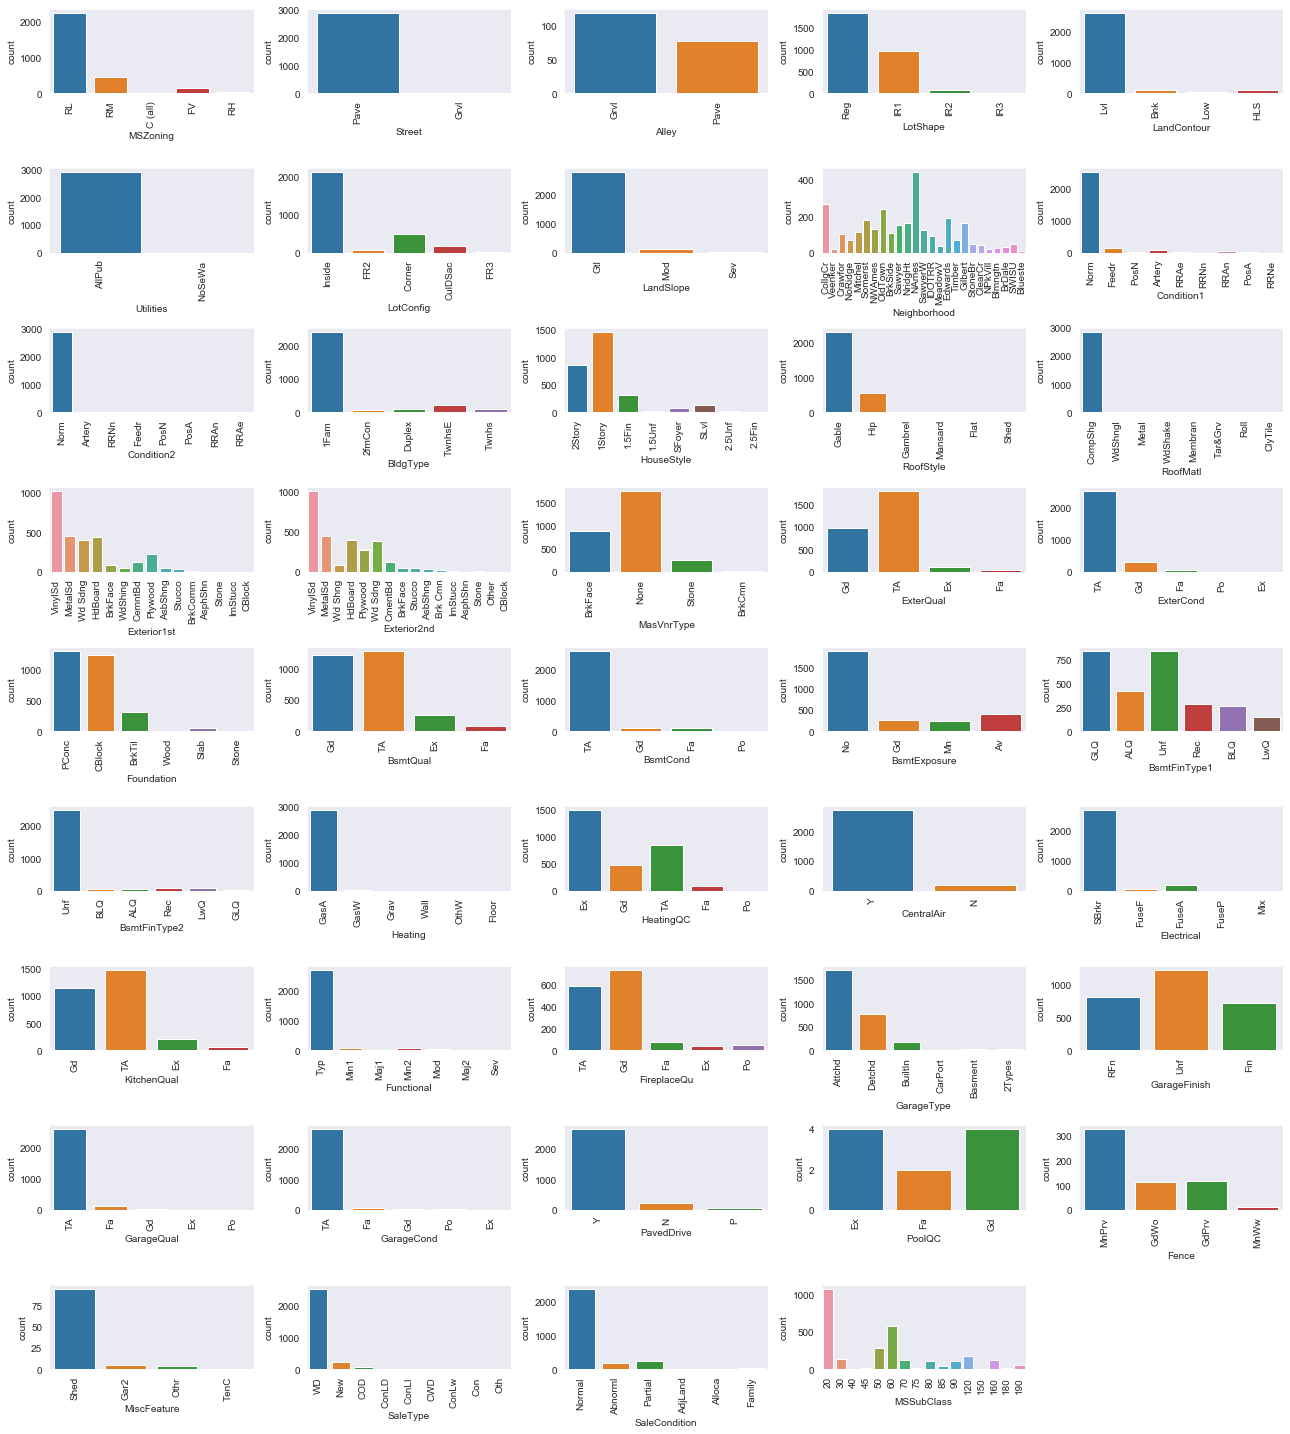

In [13]:
fig = plt.figure(figsize=(18,20))
for index in range(len(cat_feat.columns)):
    plt.subplot(9,5,index+1)
    sns.countplot(x=cat_feat.iloc[:,index], data=cat_feat.dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)


Как мы видим, некоторые признаки имеют только одно значение, что так же делает их бессмысленными для модели обучения.

### Корреляционный анализ

Для поиска мультикоколлиниарности числовых признаков и линейной зависимости с целевой переменной будем исользовать матрицу корреляций. Нет смысла оставлять в данных несколько признаков с достаточно линейной зависимостью между ними. А так же нет смысла оставлять признаки, которые почти не влияют на целевую переменную.

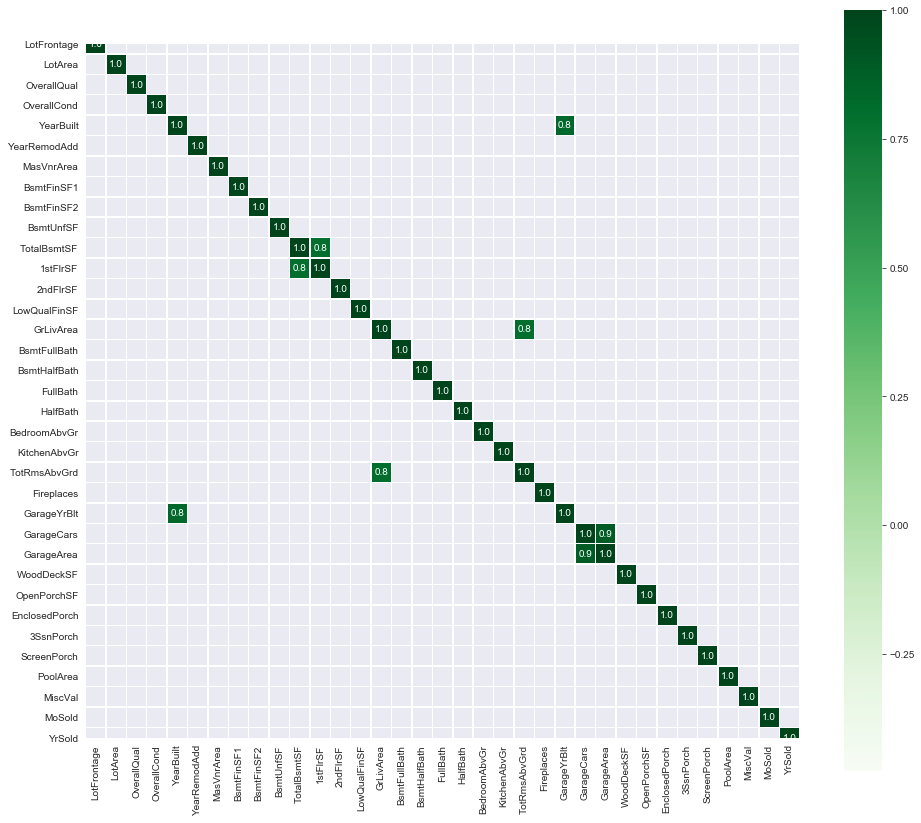

In [14]:
plt.figure(figsize=(16,14))
correlation = num_feat.corr()
sns.heatmap(correlation, square=True,
              annot=True, fmt=".1f", mask = correlation <0.75, linewidth=0.5, cmap='Greens')

Коррелирующие признаки:

    1stFlrSF    & TotalBsmtSF
    TotRmsAbvGr & GrLivArea
    GarageYrBlt & YearBuilt
    GarageArea  & GarageCars
    
Есть смысл оставить в наших данных по одному из этих признаков

Для того, чтобы оценить какие признаки сильно влияют на SalePrice, а какие почти не влияют, так же используем матрицу корреляций. Здесь нам нужны тренировочная выборка с известным целевым признаков.

In [15]:
num_train = train.select_dtypes(exclude = ['O'])
num_feat_corr = abs(num_train.corr()['SalePrice']).sort_values(ascending = False)
num_feat_corr

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePrice, dtype: float64

Ключевыми признаками в нашей выборке являются OverallQual, GrLivArea, именно они будут вносить основной вклад в обучение модели. 

На этом первичный анализ данных закончен. Мы выявили:
- признаки, для которых значения почти во всех случаях равны 0
- признаки у которых выделяется всего одно значение подавляющее число раз над другими значениями
- признаки, коррелирующие друг с другом
- признаки, которые линейно зависимы с целевой перменной, или наоборот почти не зависимы
- признаки с выбросами

### Обработка данных

Удаляем мультиколлениарные признаки

In [16]:
df.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars'], axis=1, inplace=True)

Удаляем признаки с неприемлимо большим кол-вом пропуском

df.isna().sum().sort_values(ascending = False).head(20)

In [17]:
df.drop(['PoolQC','MiscFeature','Alley'], axis=1, inplace=True)

Удаляем бесполезные фичы в прогнозировании целевой переменной

In [18]:
useless_feat = num_feat_corr[num_feat_corr < 0.05]
useless_feat

MoSold          0.046432
3SsnPorch       0.044584
YrSold          0.028923
LowQualFinSF    0.025606
MiscVal         0.021190
BsmtHalfBath    0.016844
BsmtFinSF2      0.011378
Name: SalePrice, dtype: float64

In [19]:
df.drop(['MoSold', 'YrSold'], axis = 1, inplace = True)

Дальше нас интересуют признаки с подавляющим числом встречаний одного значения. 

In [20]:
cat_col = df.select_dtypes(include=['object']).columns
overfit_cat = []
for i in cat_col:
    counts = df[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(df) * 100 > 96:
        overfit_cat.append(i)

overfit_cat = list(overfit_cat)
df = df.drop(overfit_cat, axis=1)

In [21]:
num_col = df.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).columns
overfit_num = []
for i in num_col:
    counts = df[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(df) * 100 > 96:
        overfit_num.append(i)

overfit_num = list(overfit_num)
df = df.drop(overfit_num, axis=1)

In [22]:
print("Categorical Features with >96% of the same value: ",overfit_cat)
print("Numerical Features with >96% of the same value: ",overfit_num)

Categorical Features with >96% of the same value:  ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']
Numerical Features with >96% of the same value:  ['LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal']


Признаки с выбросами: LotFrontage, LotArea, BsmtFinSF1, TotalBsmtSF, GrLivArea

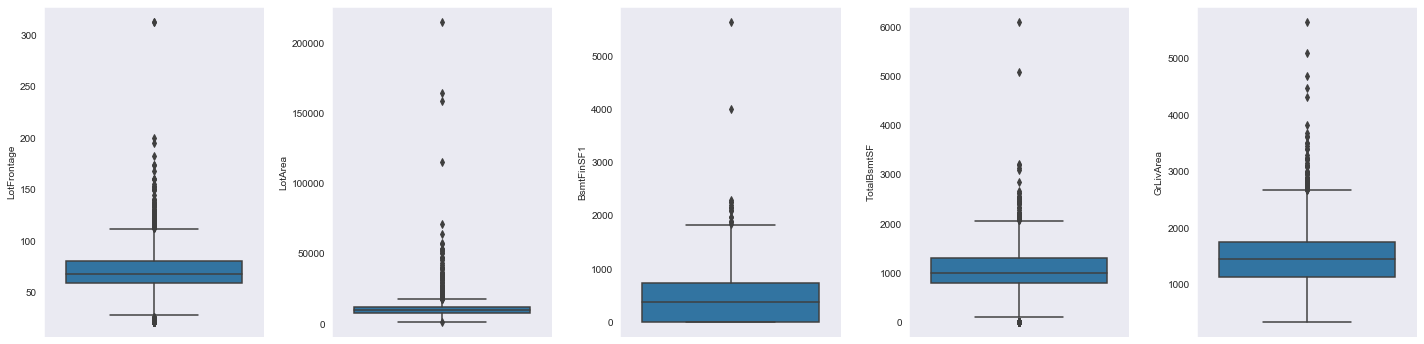

In [23]:
out_col = ['LotFrontage','LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea']
fig = plt.figure(figsize=(20,5))
for index,col in enumerate(out_col):
    plt.subplot(1,5,index+1)
    sns.boxplot(y=col, data=df)
fig.tight_layout(pad=1.5)

Мы удаляем из тренировочной выборки строки с выбросами. Такие строки будут пагубно влиять на модель обучения.

In [24]:
train = train.drop(train[train['LotFrontage'] > 200].index)
train = train.drop(train[train['LotArea'] > 100000].index)
train = train.drop(train[train['BsmtFinSF1'] > 4000].index)
train = train.drop(train[train['TotalBsmtSF'] > 5000].index)
train = train.drop(train[train['GrLivArea'] > 4000].index)

Наша модель машинного обучения не в состоянии справиться с отсутствующими значениями, поэтому нам необходимо справляться с ними на основе нашего понимания функций. Эти пропущенные значения обозначаются как NAN

In [25]:
pd.DataFrame(df.isna().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(15)

,sum
Fence,2348
FireplaceQu,1420
LotFrontage,486
GarageFinish,159
GarageCond,159
GarageQual,159
GarageType,157
BsmtCond,82
BsmtExposure,82
BsmtQual,81


Заменим пропуски на 'NA'

In [26]:
cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
       'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu','Fence',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']

df[cat] = df[cat].fillna("NA")

Категориальные признаки.
Мы заменим недостающие значения наших категориальных признаков наиболее часто встречающимися значениями.

In [27]:
#categorical
cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]
df[cols] = df.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mode()[0]))

Для числовых объектов общим подходом будет замена отсутствующего значения на среднее значение распределения признаков.
Тем не менее, некоторые функции, такие как LotFrontage и GarageArea, широко распространены. Взяв средние значения по соседствам, мы увидим, что среднее значение сильно отличается от простого получения среднего значения этих отдельных столбцов, поскольку в каждом районе есть разные средние значения LotFrontage и GarageArea. Следовательно, я решил сгруппировать эти особенности по соседствам, чтобы рассчитать соответствующие средние значения.

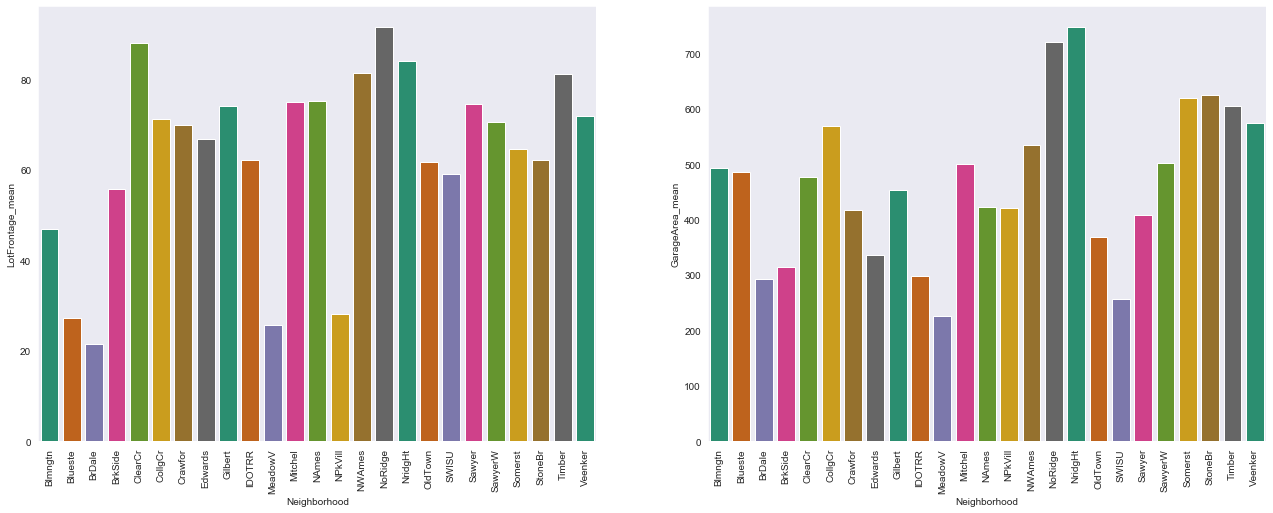

In [28]:
neigh_lot = df.groupby('Neighborhood')['LotFrontage'].mean().reset_index(name='LotFrontage_mean')
neigh_garage = df.groupby('Neighborhood')['GarageArea'].mean().reset_index(name='GarageArea_mean')

fig, axes = plt.subplots(1,2,figsize=(22,8))
axes[0].tick_params(axis='x', rotation=90)
sns.color_palette("BuGn_r")
sns.barplot(x='Neighborhood', y='LotFrontage_mean', palette="Dark2", data=neigh_lot, ax=axes[0])
axes[1].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='GarageArea_mean', palette="Dark2",data=neigh_garage, ax=axes[1])
#sns.color_palette("BuGn_r")

In [29]:
#для коррелированных признаков
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
df['GarageArea'] = df.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.mean()))
df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

#numerical
cont = ["BsmtFullBath", "BsmtHalfBath", "BsmtFinSF1", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea", "BsmtFinSF2"]
df[cont] = df[cont] = df[cont].fillna(df[cont].mean())

In [30]:
#Признак MSSubClass представляет собой категориальный признак, записанный через целые числа
df['MSSubClass'] = df['MSSubClass'].apply(str)

Так же у нас имеются признаки, которые представляют качество или состояние определенных особенностей жилья

In [31]:
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

In [32]:
ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
for col in ord_col:
    df[col] = df[col].map(ordinal_map)
    
fin_col = ['BsmtFinType1','BsmtFinType2']
for col in fin_col:
    df[col] = df[col].map(fintype_map)

df['BsmtExposure'] = df['BsmtExposure'].map(expose_map)
df['Fence'] = df['Fence'].map(fence_map)

После удаления выбросов, сильно коррелированных функций и замены пропущенных значений мы можем приступить к добавлению дополнительной информации для нашей модели для обучения.

## Feature Engineering



Feature Engineering - это метод, с помощью которого мы создаем новые функции, которые могут помочь в прогнозировании нашей целевой переменной, в данном случае это SalePrice. В этой записной книжке мы создадим дополнительные функции, основанные на наших знаниях предметной области о жилищных функциях

Основываясь на имеющейся у нас функции, первым дополнительным атрибутом, который мы можем добавить, будет TotalLot, который суммирует как LotFrontage, так и LotArea, чтобы определить общую площадь земли, доступную как участок. Мы также можем рассчитать общую площадь поверхности дома, TotalSF, добавив площадь из подвала и 2-го этажа. TotalBath также может быть использован для определения общего количества ванных комнат в доме. Мы также можем добавить все различные типы подъездов вокруг дома и обобщить в общую площадь подъездов, TotalPorch.

In [33]:
df['TotalLot'] = df['LotFrontage'] + df['LotArea']
df['TotalBsmtFin'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
df['TotalSF'] = df['TotalBsmtSF'] + df['2ndFlrSF']
df['TotalBath'] = df['FullBath'] + df['HalfBath']
df['TotalPorch'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['ScreenPorch']

Мы также используем простую разработку признаков, создавая двоичные столбцы для некоторых признаков, которые могут указывать на наличие (1) / отсутствие (0) некоторых особенностей дома

In [34]:
colum = ['MasVnrArea','TotalBsmtFin','TotalBsmtSF','2ndFlrSF','WoodDeckSF','TotalPorch']

for col in colum:
    col_name = col+'_bin'
    df[col_name] = df[col].apply(lambda x: 1 if x > 0 else 0)

Преобразование категорий в числовые

Поскольку машинное обучение учитывает только данные, которые имеют числовой характер, мы преобразуем оставшиеся категориальные столбцы в однозначные функции, используя метод get_dummies ().

In [35]:
df = pd.get_dummies(df)

Масштабирование данных

RobustScaler - это метод преобразование, которое удаляет медиану и масштабирует данные в соответствии с квантильным диапазоном (по умолчанию IQR: Interquartile Range). IQR - это диапазон между 1-м квартилем (25-й квантиль) и 3-м квартилем (75-й квантиль). Он также устойчив к выбросам, что делает его идеальным для данных, где имеется слишком много выбросов, что значительно сократит количество обучающих данных.

In [36]:
from sklearn.preprocessing import RobustScaler

cols = df.select_dtypes(np.number).columns
df[cols] = RobustScaler().fit_transform(df[cols])

In [37]:
y_train = np.log(y_train)

In [38]:
df.shape, train.shape, test.shape

((2919, 223), (1451, 80), (1459, 79))

In [39]:
x = df.loc[train.index]
y = y_train.loc[train.index]
x_test = df.loc[test.index]

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [41]:
gbr = GradientBoostingRegressor(learning_rate=0.02, n_estimators=2000,
                                           max_depth=5, min_samples_split=2,
                                           loss='ls', max_features=35)

xgb = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                       max_depth=3, min_child_weight=0,
                       gamma=0, subsample=0.7, reg_alpha = 0.0001,
                       colsample_bytree=0.7,
                       objective='reg:squarederror', nthread=-1,
                       scale_pos_weight=1, seed=27)

lgbm = LGBMRegressor(objective='regression',
                         num_leaves=4,
                         reg_alpha = 0.0001,
                         learning_rate=0.01,
                         n_estimators=5000,
                         max_bin=200,
                         bagging_fraction=0.75,
                         bagging_freq=5,
                         bagging_seed=7,
                         feature_fraction=0.2,
                         feature_fraction_seed=7,
                         verbose=-1,
                                       )

cb = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')

In [42]:
gbr.fit(x, y)
xgb.fit(x, y)   
lgbm.fit(x, y)   
cb.fit(x, y)   

In [43]:
def blend_models_predict(x, a, b, c, d):
    return ((a * gbr.predict(x)) +  (b* xgb.predict(x)) + (c * lgbm.predict(x)) + (d * cb.predict(x)))

In [44]:
subm = np.exp(blend_models_predict(x_test, 0.65, 0.15, 0.15, 0.05))

In [45]:
subm

array([127811.53739303, 160444.4891788 , 189178.13749436, ...,
       159028.34792252, 114770.42013354, 217380.19057407])

In [51]:
mean_absolute_error(subm, y_test.SalePrice)

55033.721392417596

In [50]:
y_test

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [52]:
submission = pd.DataFrame({'Id': x_test.index, 'SalePrice': subm})

submission.to_csv("submission.csv", index=False)